# Notebook to visualise HPS and ITI-GEN embeddings
## Reproducibility of "ITI-Gen: Inclusive Text-to-Image generation"

In [2]:
# import argparse, os, sys, glob
# import cv2
import torch
import numpy as np
import clip
# from omegaconf import OmegaConf
from PIL import Image
# from tqdm import tqdm, trange
# from imwatermark import WatermarkEncoder
# from itertools import islice
# from einops import rearrange
# from torchvision.utils import make_grid
# import time
# from pytorch_lightning import seed_everything
# from torch import autocast
# from contextlib import contextmanager, nullcontext
import matplotlib.pyplot as plt
from umap import UMAP
import os

## Helper functions

In [3]:
def prompt_tokenization(prompt, number = 1):
    """
    tokenize the text prompt
    :return:
    """
    # text_queries = prompt
    text_queries = [prompt] * number
    tokenized_text_queries = clip.tokenize(text_queries)
    return tokenized_text_queries, tokenized_text_queries[-1].argmax()
    
def setup_clip_model():
    clip_model, preprocess = clip.load("ViT-L/14", device="cpu")
    # self.clip_model, _ = clip.load("ViT-L/14", device="cuda") # Liang
    device = "cuda".format(1) if torch.cuda.is_available() else "cpu" # Liang
    print(f"Device used {device}")
    clip_model.to(device)
    clip_model.eval()

    return clip_model, preprocess

def ori_text_feature_extraction(tokenized_text_queries, clip_model, device):
    """
    get the text features for self.args.prompt/self.tokenized_text_queries
    for computing semantic consistency loss
    :return:
    """
    with torch.no_grad():
        xp = clip_model.token_embedding(tokenized_text_queries.to(device)).type(clip_model.dtype)  # (108, 77, 768)
        text_queries_embedding = xp + clip_model.positional_embedding.type(clip_model.dtype)

        xp = text_queries_embedding.permute(1, 0, 2)
   
        for ll in range(clip_model.transformer.layers):
            xp = clip_model.transformer.resblocks[ll](xp)
      
        xp = xp.permute(1, 0, 2)
        xp = clip_model.ln_final(xp).type(clip_model.dtype)  # (108, 77, 768)
        xp_feat = xp[torch.arange(xp.shape[0]), tokenized_text_queries.argmax(dim=-1)] @ clip_model.text_projection  # 108*768
        ori_text_feature = xp_feat / xp_feat.norm(dim=1, keepdim=True) # (108, 768)

    return ori_text_feature

CelebA_attribute_list = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald',
                         'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
                         'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
                         'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
                          'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
                         'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks',
                          'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
                         'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
FairFace_attribute_list = ['Age'] # may add Gender, Race if you want
FAIR_attribute_list = ['Skin_tone']
LHQ_attribute_list = ['Bright', 'Colorful', 'Complex', 'Contrast', 'Good', 'Happy', 'Natural', 'New', 'Noisy', 'Scary', 'Sharp']

# get the category value for different dataset
reference_image_category = {"celeba":['positive', 'negative'],
                            "fairface":['0_2','3_9','10_19','20_29','30_39','40_49','50_59','60_69','more_than_70'],
                            "FAIR_benchmark":['1','2','3','4','5','6'],
                            "lhq":['0','1','2','3','4']}
def get_dataset_for_attribute(attribute):
    """
    Determine the dataset for each attribute

    """
    if attribute in CelebA_attribute_list:
        return "celeba"
    elif attribute in FairFace_attribute_list:
        return "fairface"
    elif attribute in FAIR_attribute_list:
        return "FAIR_benchmark"
    elif attribute in LHQ_attribute_list:
        return "lhq"
    else:
        raise ValueError(f"Unknown attribute: {attribute}")
        # Not implemented yet, add your own set and attribute

def get_combinations(attributes):
    """
    Get combinations
    
    """
    datasets = [get_dataset_for_attribute(attr) for attr in attributes]
    category_lists = [reference_image_category[dataset] for dataset in datasets]

    # Using itertools product to get combinations
    from itertools import product
    return list(product(*category_lists))

def get_folder_names_and_indexes(attributes):
    """
    Generate folder names and indexes
    
    """
    combinations = get_combinations(attributes)
    folder_names = []

    for combo in combinations:
        name_parts = []
        for attr, cat in zip(attributes, combo):
            name_parts.append(f"{attr}_{cat}")
        folder_name = "_".join(name_parts)
        folder_names.append(folder_name)

    # Pair each folder name with an index
    folder_with_indexes = {folder_name: idx for idx, folder_name in enumerate(folder_names)}

    return folder_with_indexes


## Set up Clip and device

In [7]:
clip_model, preprocess = setup_clip_model()
device = "cpu"

Device used cpu


## Get file names

In [12]:
# Eyeglass positive man
folder_path = ['eyeglass_positive_Man', 'eyeglass_positive_Woman', 'eyeglass_negative_Man', 'eyeglass_negative_Woman']

for folder in folder_path:
    for filename in os.listdir(folder):
        if filename == '.DS_Store':
            os.remove(os.path.join(folder, filename))
        
file_names_pos_man = os.listdir('eyeglass_positive_Man')
file_names_neg_man = os.listdir('eyeglass_negative_Man')
file_names_pos_woman = os.listdir('eyeglass_positive_Woman')
file_names_neg_woman = os.listdir('eyeglass_negative_Woman')
print(f"Total eyeglass positive Man: {len(file_names_pos_man)} ")
print(f"Total eyeglass negative Man: {len(file_names_neg_man)} ")
print(f"Total eyeglass positive woman: {len(file_names_pos_woman)} ")
print(f"Total eyeglass negative woman: {len(file_names_neg_woman)} ")

Total eyeglass positive Man: 145 
Total eyeglass negative Man: 85 
Total eyeglass positive woman: 49 
Total eyeglass negative woman: 114 


In [13]:
man_glasses_features = torch.zeros((49, 768))
woman_glasses_features = torch.zeros((49, 768))

man_noglasses_features = torch.zeros((49, 768))
woman_noglasses_features = torch.zeros((49, 768))

for i in range(49):
    image_pos_man = preprocess(Image.open('eyeglass_positive_Man/' + file_names_pos_man[i])).unsqueeze(0).to(device)
    image_pos_woman = preprocess(Image.open('eyeglass_positive_Woman/' + file_names_pos_woman[i])).unsqueeze(0).to(device)

    image_neg_man = preprocess(Image.open('eyeglass_negative_Man/' + file_names_neg_man[i])).unsqueeze(0).to(device)
    image_neg_woman = preprocess(Image.open('eyeglass_negative_Woman/' + file_names_neg_woman[i])).unsqueeze(0).to(device)

    with torch.no_grad():
        # POSTIVE
        image_features_man = clip_model.encode_image(image_pos_man)
        image_features_man = image_features_man/ image_features_man.norm(dim=1, keepdim=True)  
        man_glasses_features[i] = image_features_man

        image_features_woman = clip_model.encode_image(image_pos_woman)
        image_features_woman = image_features_woman/ image_features_woman.norm(dim=1, keepdim=True)  
        woman_glasses_features[i] = image_features_woman

        # NEGATIVE
        image_features_man = clip_model.encode_image(image_neg_man)
        image_features_man = image_features_man/ image_features_man.norm(dim=1, keepdim=True)  
        man_noglasses_features[i] = image_features_man

        image_features_woman = clip_model.encode_image(image_neg_woman)
        image_features_woman = image_features_woman/ image_features_woman.norm(dim=1, keepdim=True)  
        woman_noglasses_features[i] = image_features_woman   

## Visualise CLIP embeddings of the reference images (Eyeglasses)

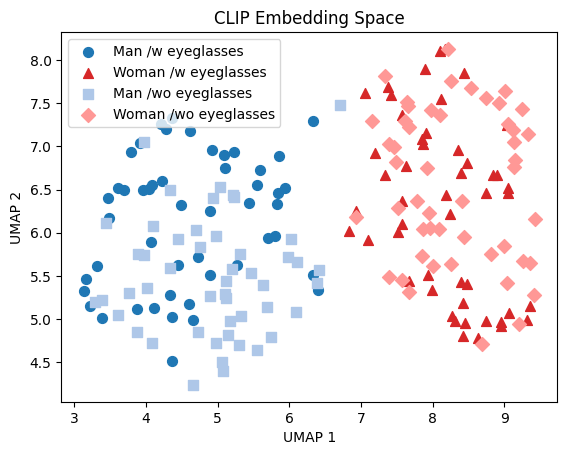

In [ ]:
featues_pos_neg = torch.cat((man_glasses_features, woman_glasses_features, man_noglasses_features, woman_noglasses_features), dim = 0)
nr = 49

plt.rcParams['font.family'] = 'Times New Roman'
# Apply UMAP for dimensionality reduction to 2D
umap = UMAP(n_components=2)
umap_result = umap.fit_transform(featues_pos_neg.detach().numpy())

colors = plt.get_cmap('tab20')

plt.scatter(umap_result[0:nr, 0], umap_result[0:nr, 1], color=colors(0), label='Man /w eyeglasses', s=50, marker='o')
plt.scatter(umap_result[nr:2*nr, 0], umap_result[nr:2*nr, 1], color=colors(6), label='Woman /w eyeglasses', s=50, marker='^')
plt.scatter(umap_result[2*nr:3*nr, 0], umap_result[2*nr:3*nr, 1], color=colors(1), label='Man /wo eyeglasses', s=50, marker='s')
plt.scatter(umap_result[3*nr:4*nr, 0], umap_result[3*nr:4*nr, 1], color=colors(7), label='Woman /wo eyeglasses', s=50, marker='D')

plt.title('CLIP Embedding Space', fontsize=20)
plt.xlabel('UMAP 1', fontsize=16)
plt.ylabel('UMAP 2', fontsize=16)
plt.legend()
# plt.tight_layout()
plt.savefig('strong_weak_categories.pdf', tight_layout=True, dpi=300)
plt.show()

## Get text embedding (clip) and trained ITI-GEN embedding

In [ ]:
def get_embeddings(prompt_path, prompt_pos, prompt_neg):
    # parse settings and device
    device = "cuda".format(1) if torch.cuda.is_available() else "cpu" # Liang
    emb = torch.load(prompt_path).to(device)

    # embed prompt and get original text features
    tokenized_text_queries_pos, max_tokenized_text_queries = prompt_tokenization(prompt_pos, len(emb))
    ori_text_feature_pos = ori_text_feature_extraction(tokenized_text_queries_pos, clip_model, device)
    
    tokenized_text_queries_neg, max_tokenized_text_queries = prompt_tokenization(prompt_neg, len(emb))
    ori_text_feature_neg = ori_text_feature_extraction(tokenized_text_queries_neg, clip_model, device)

    text_features = emb
    text_features = text_features[torch.arange(text_features.shape[0]), 6 + 3] @ clip_model.text_projection  # (108, 768)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)  # (108, 768)

    return torch.cat((text_features, ori_text_feature_pos[0].unsqueeze(0), ori_text_feature_neg[0].unsqueeze(0)), dim=0) 


In [ ]:
prompt_pos = 'a headshot of a man'
prompt_neg = 'a headshot of a person'
prompt_path = 'ckpts/a_headshot_of_a_person_Male/original_prompt_embedding/basis_final_embed_29.pt'

embeddings_male = get_embeddings(prompt_path, prompt_pos, prompt_neg)

prompt_pos = 'a headshot of a young person'
prompt_neg = 'a headshot of an old person '
prompt_path = 'ckpts/a_headshot_of_a_person_Young/original_prompt_embedding/basis_final_embed_29.pt'

embeddings_young = get_embeddings(prompt_path, prompt_pos, prompt_neg)

prompt_pos = 'a headshot of a person with eyeglasses'
prompt_neg = 'a headshot of a person without eyeglasses '
prompt_path = 'ckpts/a_headshot_of_a_person_Eyeglasses/original_prompt_embedding/basis_final_embed_29.pt'

embeddings_glasses = get_embeddings(prompt_path, prompt_pos, prompt_neg)

prompt_pos = 'a headshot of a person with mustache'
prompt_neg = 'a headshot of a person without mustache'
prompt_path = 'ckpts/a_headshot_of_a_person_Mustache/original_prompt_embedding/basis_final_embed_29.pt'

embeddings_mustache = get_embeddings(prompt_path, prompt_pos, prompt_neg)

embeddings = torch.cat((embeddings_male, embeddings_young, embeddings_glasses, embeddings_mustache), dim = 0)

torch.Size([16, 768])


## Visualise ITI-GEN and HPS embedding for various categories

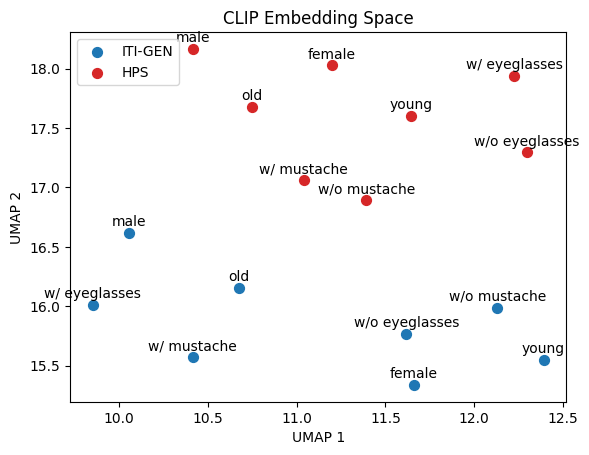

In [ ]:
# Apply UMAP for dimensionality reduction to 2D
umap = UMAP(n_components=2)
umap_result = umap.fit_transform(embeddings.detach().numpy())

colors = plt.get_cmap('tab20')
labels = ['male', 'female', 'male', 'female', 'young', 'old', 'young', 'old', 'w/ eyeglasses', 'w/o eyeglasses', 'w/ eyeglasses', 'w/o eyeglasses', 'w/ mustache', 'w/o mustache', 'w/ mustache', 'w/o mustache']

plt.scatter(umap_result[np.array([0, 1, 4, 5, 8, 9, 12, 13]), 0], umap_result[np.array([0, 1, 4, 5, 8, 9, 12, 13]), 1], color=colors(0), label='ITI-GEN', s=50)
plt.scatter(umap_result[np.array([2, 3, 6, 7, 10, 11, 14, 15]), 0], umap_result[np.array([2, 3, 6, 7, 10, 11, 14, 15]), 1], color=colors(6), label='HPS', s=50)

# Annotate each point with vector label
for i, (x, y) in enumerate(umap_result):
    plt.annotate(labels[i], (x, y), textcoords="offset points", xytext=(0, 5), ha='center')

plt.title('CLIP Embedding Space')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.show()